In [99]:
# importing libraries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import folium
import random
import math
import time

import plotly.graph_objects as go
import seaborn as sns
import ipywidgets as widgets

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator
plt.style.use('seaborn')

In [100]:
death_df = pd.read_csv('https://raw.githubusercontent.com/OliverArthur/covid-19-rd-data/master/death.csv')
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/OliverArthur/covid-19-rd-data/master/confirmed.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/OliverArthur/covid-19-rd-data/master/recovered.csv')
provinces_df = pd.read_csv('https://raw.githubusercontent.com/OliverArthur/covid-19-rd-data/master/provinces.csv')
case_per_provinces_df = pd.read_csv('https://raw.githubusercontent.com/OliverArthur/covid-19-rd-data/master/case-per-provinces.csv')

In [101]:
# clean data
death_df.columns = map(str.lower, death_df.columns)
confirmed_df.columns = map(str.lower, confirmed_df.columns)
recovered_df.columns = map(str.lower, recovered_df.columns)
provinces_df.columns = map(str.lower, provinces_df.columns)

## ¿Qué es COVID-19?

Los coronavirus son una gran familia de virus que pueden causar enfermedades respiratorias en los seres humanos, desde resfriados comunes hasta condiciones más graves como el síndrome respiratorio agudo severo (SARS) y el síndrome respiratorio de Oriente Medio (MERS).

1. El nuevo coronavirus es una nueva cepa de coronavirus no identificada anteriormente. 
2. El nuevo coronavirus involucrado en el brote actual ha sido nombrado SARS-CoV-2 por la Organización Mundial de la Salud (OMS).
3. La enfermedad que causa ha sido denominada "enfermedad coronavirus 2019" (o "COVID-19").

In [102]:
confirmed_df.head()
cols = confirmed_df.keys()
confirmed = confirmed_df.loc[:, cols[3]:cols[-1]]
deaths = death_df.loc[:, cols[3]:cols[-1]]
recovered_list = recovered_df.loc[:, cols[3]:cols[-1]]

dates = confirmed.keys()
confirmed_total = []
deaths_total = []
recovered_total = []
for i in dates:
    confirmed_sum = confirmed[i].sum()
    deaths_sum = deaths[i].sum()
    recovered_sum = recovered_list[i].sum()
    confirmed_total.append(confirmed_sum)
    deaths_total.append(deaths_sum)
    recovered_total.append(recovered_sum)
    

In [103]:
# number of provicens to enter
fig = go.FigureWidget( layout=go.Layout() )
def highlight_col(x):
    r = 'background-color: red'
    y = 'background-color: purple'
    g = 'background-color: grey'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 4] = y
    df1.iloc[:, 5] = r
    df1.iloc[:, 6] = g
    
    return df1

def show_latest_cases(n):
    n = int(n)
    return case_per_provinces_df.sort_values('confirmados', ascending= False).head(n).style.apply(highlight_col, axis=None)

interact(show_latest_cases, n='10')

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none'
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(Text(value='10', description='n'), Output()), _dom_classes=('widget-interact',))

    'data': [], 'layout': {'template': '...'}
}),), layout=Layout(border='solid …

In [104]:
display(HTML("<div style = 'background-color: #504e4e; padding: 30px '>" +
             "<span style='color: #fff; font-size:30px;'> Confirmados: "  + str(confirmed_sum) +"</span>" +
             "<span style='color: red; font-size:30px;margin-left:20px;'> Muertos: " + str(deaths_sum) + "</span>"+
             "<span style='color: lightgreen; font-size:30px; margin-left:20px;'> Recuperados: " + str(recovered_sum) + "</span>"+
             "</div>")
       )

In [105]:
sorted_provinces_df = case_per_provinces_df.sort_values('confirmados', ascending= False)

In [106]:
# # plotting the 10 worst hit provinces
def bubble_chart(n):
    fig = px.scatter(sorted_provinces_df.head(n), x="provincia", y="confirmados", size="confirmados", color="provincia",
               hover_name="provincia", size_max=60)
    fig.update_layout(
    title=str(n) +" Las provincias más afectados",
    xaxis_title="Provincias",
    yaxis_title="Casos confirmados",
    width = 700
    )
    fig.show()

interact(bubble_chart, n=10)

ipywLayout = widgets.Layout(border='solid 2px green')
ipywLayout.display='none'
widgets.VBox([fig], layout=ipywLayout)

interactive(children=(IntSlider(value=10, description='n', max=30, min=-10), Output()), _dom_classes=('widget-…

    'data': [], 'layout': {'autosize': True, 'template': '...'}
}),), layout=Lay…

In [107]:
px.bar(
    sorted_provinces_df.head(10),
    x = "provincia",
    y = "confirmados",
    title= "Top 10 provincias mas afectadas", # the axis names
    color_discrete_sequence=["cyan"], 
    height=500,
    width=800
)

In [108]:
px.bar(
    sorted_provinces_df.head(10),
    x = "provincia",
    y = "muertos",
    title= "Top 10 provincias con mas muertes", # the axis names
    color_discrete_sequence=["red"], 
    height=500,
    width=800
)

In [109]:
px.bar(
    sorted_provinces_df.head(10),
    x = "provincia",
    y = "recuperados",
    title= "Top 10 provincias con mas casos de recuperados", # the axis names
    color_discrete_sequence=["green"], 
    height=500,
    width=800
)

In [110]:
RD_COORDINATES = (18.606258, -70.106722)
provinces_map = folium.Map(location=RD_COORDINATES, tiles="cartodbpositron", zoom_start=6, max_zoom=24, min_zoom = 2)

for i in range(0, len(case_per_provinces_df)):
    folium.Circle(
        location=[case_per_provinces_df.loc[i]['lat'], case_per_provinces_df.loc[i]['long']],
        fill=True,
        radius=(int((np.log(case_per_provinces_df.iloc[i]['confirmados']+1.00001)))+0.2)*4000,
        color='red',
        fill_color='indigo',
        tooltip="<div style='margin: 0; background-color: black; color: white;'>"+
            "<h4 style='text-align:center;font-weight: bold'>"+case_per_provinces_df.iloc[i]['provincia'] + "</h4>"
            "<ul style='color: white;;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
            "<li>Confirmed: "+str(case_per_provinces_df.iloc[i]['confirmados'])+"</li>"+
                        "<li>Deaths:   "+str(case_per_provinces_df.iloc[i]['muertos'])+"</li>"+
                    "</ul></div>",
        
    ).add_to(provinces_map)

provinces_map

In [111]:
days_since_03_19 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_cases = np.array(confirmed_total).reshape(-1, 1)

In [112]:
days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjust_dates = future_forecast[:-10]

start = '03/19/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days=1)).strftime('%m/%d/%Y'))

latest_confirmed = confirmed_df[dates[-1]]

y_test_confirmed=train_test_split(days_since_03_19, total_cases, test_size=0.15, shuffle=False)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed= \
    train_test_split(days_since_03_19, total_cases, test_size=0.15, shuffle=False)

In [113]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma': gamma, 'epsilon': epsilon, 'shrinking': shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid)
svm_search.fit(X_train_confirmed, y_train_confirmed)

/Users/oliverarthur/.local/share/virtualenvs/covid-19_RD-tPzsZrqz/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/oliverarthur/.local/share/virtualenvs/covid-19_RD-tPzsZrqz/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/oliverarthur/.local/share/virtualenvs/covid-19_RD-tPzsZrqz/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/oliverarthur/.local/share/virtualenvs/covid-19_RD-tPzsZrqz/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarn

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['poly', 'sigmoid', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [114]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forecast)

In [95]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)

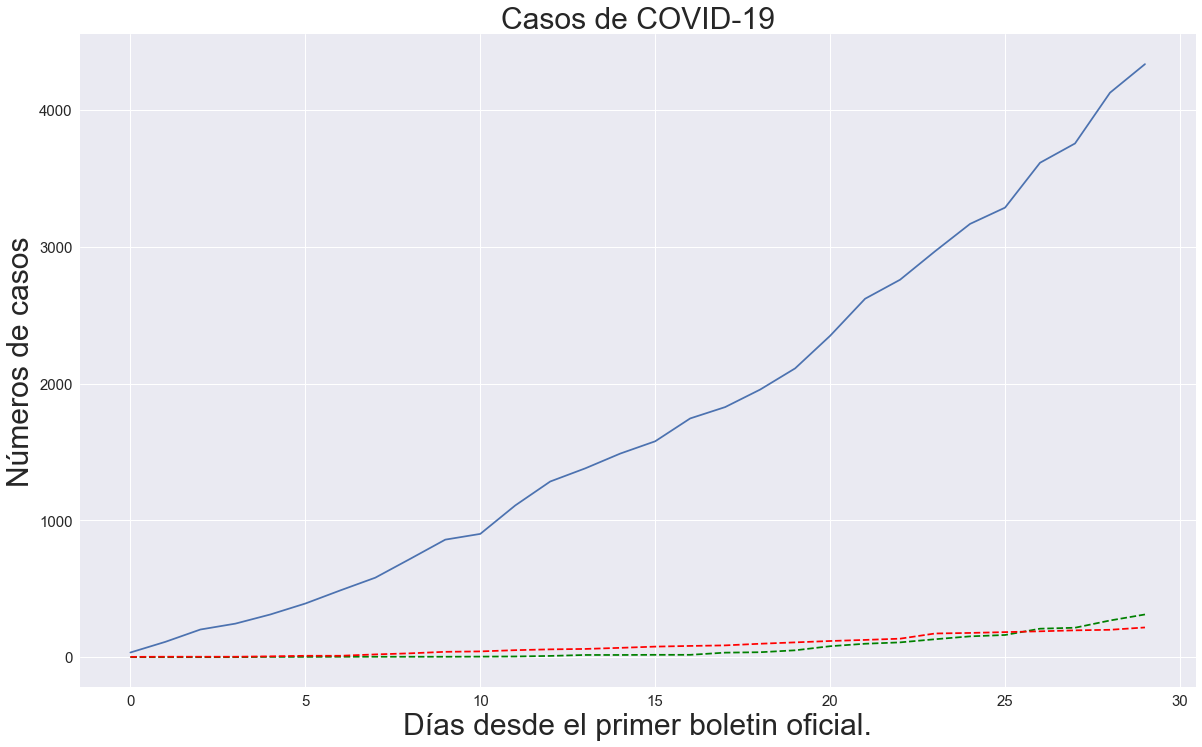

In [96]:
plt.figure(figsize=(20, 12))
plt.plot(adjust_dates, total_cases)
plt.plot(adjust_dates, recovered_total, linestyle='dashed', color='green')
plt.plot(adjust_dates, deaths_total, linestyle='dashed', color='red')
plt.title('Casos de COVID-19', size=30)
plt.xlabel('Días desde el primer boletin oficial.', size=30)
plt.ylabel('Números de casos', size=30)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

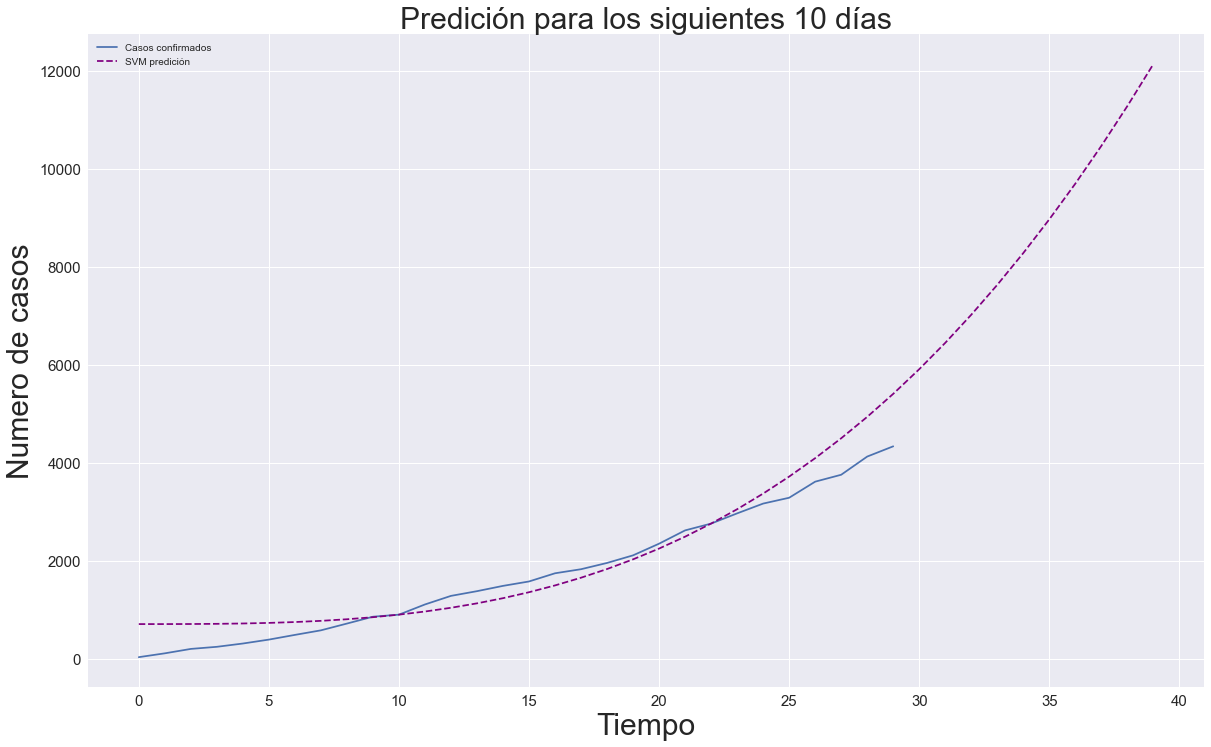

In [97]:
plt.figure(figsize=(20, 12))
plt.plot(adjust_dates, total_cases)
plt.plot(future_forecast, svm_pred, linestyle='dashed', color='purple')
plt.title('Predición para los siguientes 10 días', size=30)
plt.xlabel('Tiempo', size=30)
plt.ylabel('Numero de casos', size=30)
plt.legend(['Casos confirmados', 'SVM predición'])
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()